<a href="https://colab.research.google.com/github/henrykohl/DeepLearningByPytorchTutorial/blob/master/video_notebooks/04_pytorch_custom_datasets_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="red">04. PyTorch Custom Datasets Video Notebook</font>
We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries
Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing PyTorch and setting up device-agnostic code

```
torch.__version__
```
1.13.1+cu116


In [1]:
import torch 
from torch import nn

# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'2.0.1+cu118'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# 如果有開啟GPU
#!nvidia-smi

## 1. Get data
Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path  # 用於建立路徑

# Setup path to a data folder
"""設定data目錄路徑"""
data_path = Path("data/") 
"""設定pizza_steak_sushi目錄路徑"""                
image_path = data_path / "pizza_steak_sushi"      

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else: 
  print(f"{image_path} does not exist, creating one...")
  """建立pizza_steak_sushi目錄"""
  image_path.mkdir(parents=True, exist_ok=True)    

# Download pizza, steak and suhsi data
"""建立pizza_steak_sushi.zip檔案, 此時檔案內容是空的, wb指的是write binary"""
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:  
  # request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  request = requests.get("https://github.com/henrykohl/DeepLearningByPytorchTutorial/raw/master/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  """把request內容寫入f"""
  f.write(request.content)                 

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


In [5]:
# image_path

## 2. Becoming one with the data (data preparation and data exploration)

In [6]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
"""pizza_steak_sushi目錄下(含子目錄)所包含的檔案數與目錄數"""
walk_through_dir(image_path) 

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image
Let's write some code to:

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using pathlib.Path.parent.stem
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [9]:
image_path

PosixPath('data/pizza_steak_sushi')

In [10]:
# /content/data/pizza_steak_sushi

In [11]:
# Path('data/pizza_steak_sushi/train/steak').parent.stem

Random image path: data/pizza_steak_sushi/train/steak/1761285.jpg
Image class: steak
Image height: 384
Image width: 512


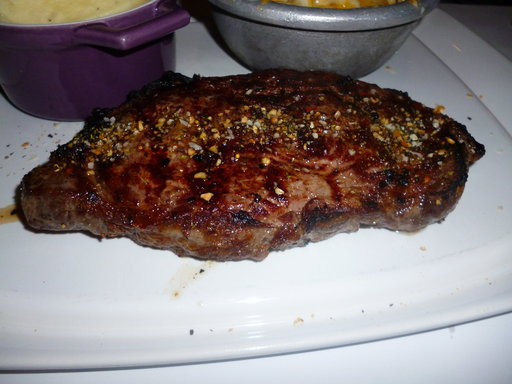

In [12]:
import random 
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths 
"""把image_path下三層（不包含本身）的所有jpg檔案的路徑，存起來"""
image_path_list = list(image_path.glob("*/*/*.jpg")) # 

# 2. Pick a random image path
"""隨機挑選一個檔案的路徑"""
random_image_path = random.choice(image_path_list)  # 
# print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
"""被挑選檔案的目錄名"""
image_class = random_image_path.parent.stem      # 
# print(image_class)

# 4. Open image
"""img是PIL.JpegImagePlugin.JpegImageFile物件"""
img = Image.open(random_image_path)         # 

# 5. Print metadata 
print(f"Random image path: {random_image_path}")  # 顯示被挑選檔案的路徑
print(f"Image class: {image_class}")         # 顯示被挑選檔案的目錄名
print(f"Image height: {img.height}")         # 顯示(圖)檔案的高
print(f"Image width: {img.width}")          # 顯示(圖)檔案的寬
img

In [13]:
##Try to visualize and image with matplotlib...

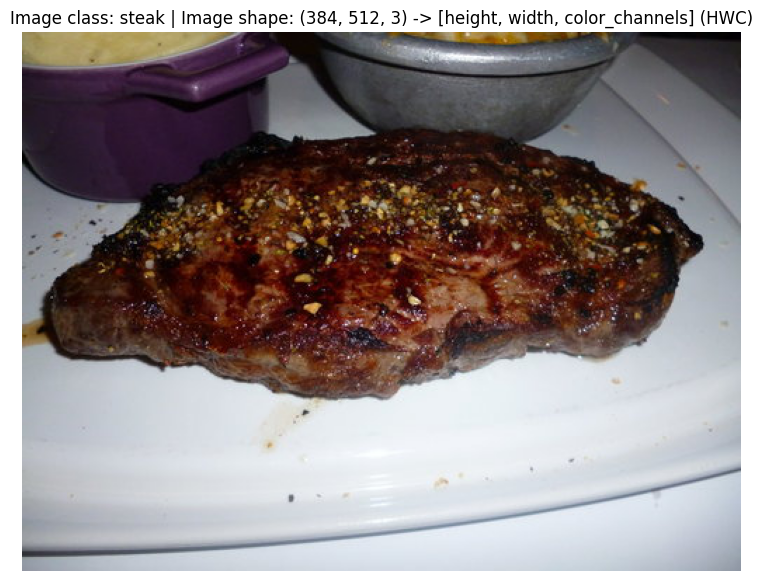

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

In [15]:
# img_as_array

In [16]:
# img_as_array.shape

In [17]:
type(img_as_array),img_as_array.dtype

(numpy.ndarray, dtype('uint8'))

## 3. Transforming data <font color="red">(開始觸及PyTorch)</font>
Before we can use our image data with PyTorch:

1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`
Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [19]:
# Write a transform for image
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() 
])

In [20]:
"""注意, 不能寫成data_transform(img_as_array), 因為輸入需為一個PIL image"""
data_transform(img).shape, data_transform(img).dtype, type(data_transform(img))

(torch.Size([3, 64, 64]), torch.float32, torch.Tensor)

<font color="red">Matplotlib 相關https://zhuanlan.zhihu.com/p/146040002</font>

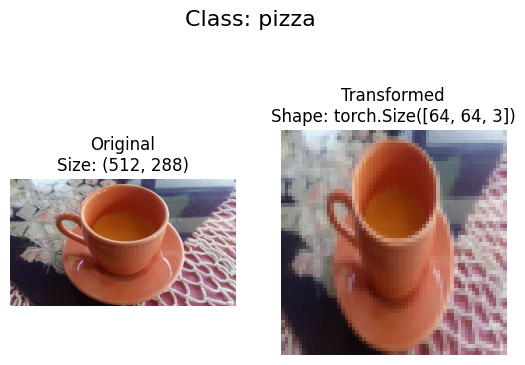

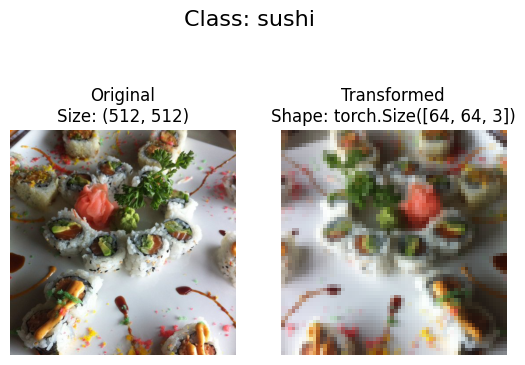

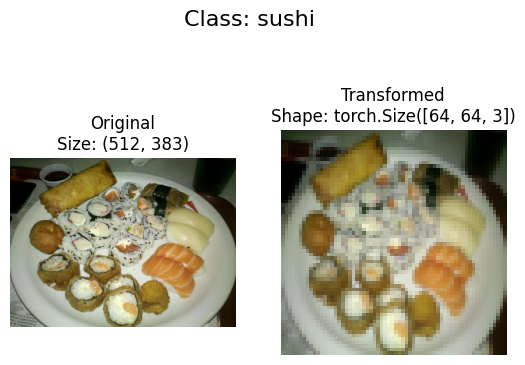

In [21]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms 
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  """從image_paths這個list裡, 選取k筆檔案路徑"""
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      # print(type(f))     # type(f)回傳<class 'PIL.JpegImagePlugin.JpegImageFile'>
      # obj = transform(f)  # type(obj)回傳<class 'torch.Tensor'>

      """構圖-方法一(自行測試)"""
      
      # fig = plt.figure(figsize=(12, 6))

      # ax1 = fig.add_subplot(121)            # 1-row 2-col 中 第1個位置
      # ax1.set_title(f"Original\nSize: {f.size}")
      # ax1.imshow(f)
      # ax1.axis("off")

      # ax2 = fig.add_subplot(1,2,2)           # 1-row 2-col 中 第2個位置
      # transformed_image = transform(f).permute(1, 2, 0)
      # ax2.set_title(f"Transformed\nShape: {transformed_image.shape}")
      # ax2.imshow(transformed_image)
      # ax2.axis("off")

      # plt.show()

      """構圖-方法二(原作者提供)"""
      
      """畫出多張圖, 注意plt.subplots不是subplot"""
      fig, ax = plt.subplots(nrows=1, ncols=2) 
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                  transform=data_transform,
                  n=3,
                  seed=None)

In [22]:
# type(f)

## 4. Option 1: Loading image data using ImageFolder
We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [23]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                   transform=data_transform, # a transform for the data
                   target_transform=None   # a transform for the label/target 
                   ) 

test_data = datasets.ImageFolder(root=test_dir,
                   transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [24]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [25]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [26]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [27]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [28]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [29]:
"""train_data[0] 是一個tuple"""
train_data[0][0].shape, train_data[0][1]

(torch.Size([3, 64, 64]), 0)

<font color="red">**img**</font> 是**train_data**中的一筆tuple資料的第一元素 <font color="red">torch.Tensor</font>

In [30]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]   # 注意，這裡的img是tensor
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

In [31]:
class_names[label]

'pizza'

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

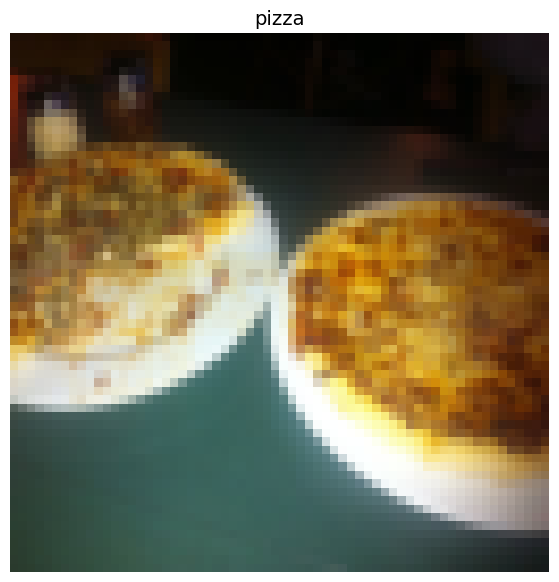

In [32]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`'s
A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [33]:
# !nvidia-smi

In [34]:
import os
os.cpu_count()

2

In [35]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader = DataLoader(dataset=train_data,
                  batch_size=BATCH_SIZE,
                  num_workers=1,
                  shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                  batch_size=BATCH_SIZE,
                  num_workers=1,
                  shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7faa99f16140>,
 <torch.utils.data.dataloader.DataLoader at 0x7faa99edff40>)

In [36]:
"""輸出會根據BATCH_SIZE大小"""
len(train_dataloader), len(test_dataloader)

(8, 3)

In [37]:
len(train_data), len(test_data)

(225, 75)

<font color="red">img</font> 從train_dataloader取出，是一個batch的 <font color="red">torch.Tensor</font>

In [38]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 5 Option 2: Loading Image Data with a Custom `Dataset`
1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:

* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:

* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [39]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [40]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names
We want a function to:

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [41]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory 
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))]) # 沒有 list 也可以
# class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory))) # 沒有 [] 也可以
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

```
for entry in list(os.scandir(target_directory)):
  print(entry)
```
<DirEntry 'sushi'><br>
<DirEntry 'steak'><br>
<DirEntry 'pizza'>


```
for entry in os.scandir(target_directory):
  print(entry)
```
<DirEntry 'sushi'><br>
<DirEntry 'steak'><br>
<DirEntry 'pizza'>



In [42]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [43]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [44]:
# 練習：建立dictionary
# dictcase = {}
# type(dictcase)

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`
To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
 * paths - paths of our images
 * transform - the transform we'd like to use
 * classes - a list of the target classes
 * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [45]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, 
          targ_dir: str, 
          transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    """目標目錄往下兩層的所有jpg檔的路徑集合"""
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # 
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    """利用5.1建立的find_classes函式"""
    self.classes, self.class_to_idx = find_classes(targ_dir) 

    """.paths, .transform, .classes, .class_to_idx 四個屬性都可以在ImageFolderCustom物件建立後被呼叫"""
    

  # 4. Create a function to load images
  """回傳一個PIL.JpegImagePlugin.JpegImageFile"""
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)                 

    """.load_image(int) 可以在ImageFolderCustom物件建立後被呼叫"""

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)  

    """呼叫方式 len(物件)"""
  
  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)         # img是PIL.JpegImagePlugin.JpegImageFile物件
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label


兩種方式結果都一樣
```
pathlib.Path('data/pizza_steak_sushi').parent.name 
pathlib.Path('data/pizza_steak_sushi').parent.stem 
```



In [46]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
                      transforms.Resize(size=(64, 64)),
                      transforms.RandomHorizontalFlip(p=0.5),
                      transforms.ToTensor() 
])

test_transforms = transforms.Compose([
                      transforms.Resize(size=(64, 64)),
                      transforms.ToTensor()
])

In [47]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                      transform=test_transforms)

In [48]:
# 測試，但既使成功，也沒有給出太多資訊
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7faa99f15db0>,
 <__main__.ImageFolderCustom at 0x7faa99f15cc0>)

In [49]:
img, label = train_data[0] 
type(img), label

(torch.Tensor, 0)

In [50]:
imgd, labd = train_data_custom[0] # 依靠__getitem__方法
type(imgd), labd

(torch.Tensor, 1)

In [51]:
len(train_data), len(train_data_custom)

(225, 225)

In [52]:
len(test_data), len(test_data_custom)

(75, 75)

In [53]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [54]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [55]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


In [56]:
# 測試load_image()方法
# train_data_custom.load_image(0)

### 5.3 Create a function to display random images
1. Take in a Dataset and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [57]:
"""從給定的dataset中, 隨意選取n張圖檔, 並顯示。n<=10"""
# 1. Create a function to take in a dataset 
def display_random_images(dataset: torch.utils.data.Dataset,
              classes: List[str] = None,
              n: int = 10,
              display_shape: bool = True,
              seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n) # 返回：k長度從序列range(len(dataset))中選擇的新元素index列表。

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx): 
    """targ_sample是random_samples_idx中一一取出的元素index  """  
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # targ_image是圖片的tensor，targ_label是圖片的label

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)    # 把圖置於1-row n-col中的第i+1的位置
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

In [58]:
# 測試random.sample
random.sample(range(len(train_data_custom)), k=10)

[24, 62, 111, 65, 192, 147, 170, 194, 43, 193]

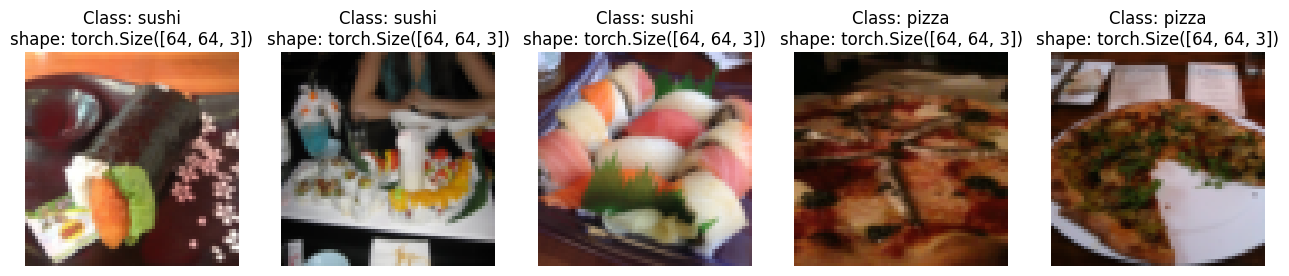

In [59]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
            n=5, 
            classes=class_names,
            seed=None)

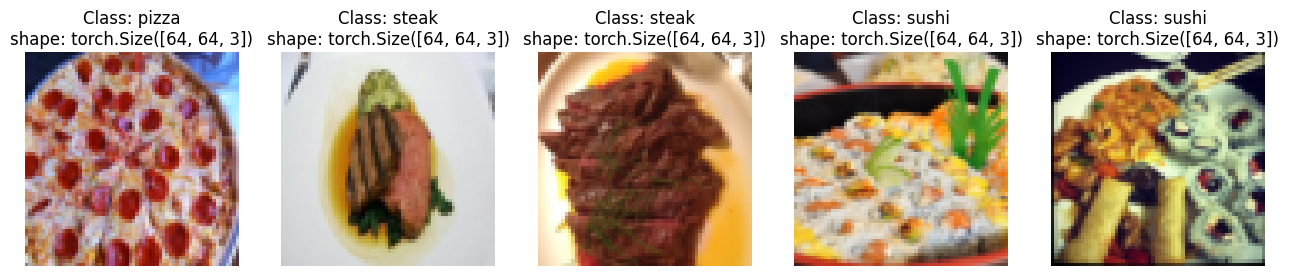

In [60]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
              n=5,        # 既使n=20，也只會顯示出10張圖。注意n>10的話，Shape不會顯示
              classes=class_names,
              seed=None)

### 5.4 Turn custom loaded images into DataLoader's

In [61]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32 # 可用1 或 32 測試，看看結果有何不同
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                      batch_size=BATCH_SIZE,
                      num_workers=0,
                      shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                      batch_size=BATCH_SIZE,
                      num_workers=NUM_WORKERS,
                      shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7faa99d2e020>,
 <torch.utils.data.dataloader.DataLoader at 0x7faa99d2d150>)

In [62]:
# Get image and label from custom datloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)
Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

In [63]:
# Let's look at trivailaugment - https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide 
from torchvision import transforms

train_transform = transforms.Compose([
                      transforms.Resize(size=(224, 224)),
                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
          # num_magnitude_bins定義了將選擇多少範圍的强度值來應用某個變量，0是無範圍，最大範圍是31（最高強度的最大機會）。
                      # 除了TrivialAugmentWide，還可以試試其他Data Augmentation 的方法
                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                      transforms.Resize(size=(224, 224)),
                      transforms.ToTensor()
])

In [64]:
image_path

PosixPath('data/pizza_steak_sushi')

In [65]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/1736968.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/421476.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1382427.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/735441.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2017387.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2603058.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3074367.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1839481.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2254705.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/234626.jpg')]

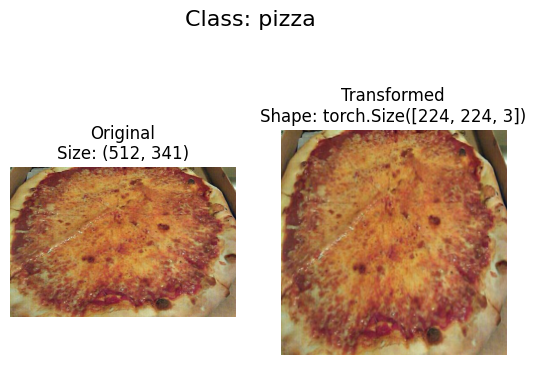

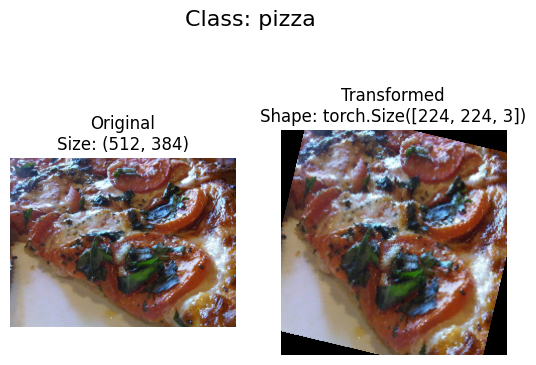

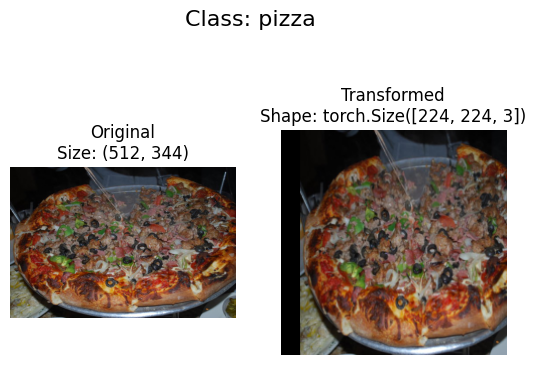

In [66]:
# Plot random transformed images
"""來自3.1"""
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation
Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [67]:
# Create simple transform
simple_transform = transforms.Compose([
                      transforms.Resize(size=(64, 64)),
                      transforms.ToTensor()
])

In [68]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                      transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                      transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                    batch_size=BATCH_SIZE,
                    shuffle=True, 
                    num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [69]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, 
          input_shape: int,
          hidden_units: int,
          output_shape: int) -> None:
    super().__init__()
    # in: (4維) (batch_size x) 3 x 64 x 64
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        # out: hidden_units x 62 x 62
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        # out: hidden_units x 60 x 60
        nn.MaxPool2d(kernel_size=2,
                  stride=2) # default stride value is same as kernel_size
        # out: hidden_units x 30 x 30
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        # out: hidden_units x 28 x 28
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        # out: hidden_units x 26 x 26
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                  stride=2) # default stride value is same as kernel_size
        # out: hidden_units x 13 x 13
    )
    self.classifier = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(in_features=hidden_units*13*13,
              out_features=output_shape)
        # out: output_shape
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html

In [70]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
          hidden_units=10, 
          output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [71]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [72]:
# Try a forward pass
# model_0(image_batch.to(device))

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [73]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions
* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

<font color="red">沿用自Lecture**3** 的 **6.2**


---
<font color="red">補充pytorch一個細節
```
tt = torch.tensor(12)
print(f"{tt}")
tt
```
12.00000 <br>
tensor(12) <br>
<font color="red">tt是一個零維的tensor,如果使用print(f"{tt}"), 則輸出的結果會是一個純量, 並非tensor, 因此下面用法是沒有問題的

```
tt = torch.tensor(12)

tt+1, tt.item()+1
```
(tensor(13), 13)




In [74]:
# Create train_step()
def train_step(model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer:torch.optim.Optimizer,
        # accuracy_fn, (Lecture3-6.2有此參數)
        device=device):
  # Put the model in train mode
  """ *訓練模式* """
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    """置放資料於設備"""
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    """步驟1 - 預測"""
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    """步驟2 - 計算loss (預測標籤在前 真實標籤在後)"""
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    """loss是一個零維的tensor, 計算train_loss時, 使用item()是標準作法, 但沒用item()也可以"""  

    # 3. Optimizer zero grad
    """步驟3 - 優化器歸零"""
    optimizer.zero_grad()

    # 4. Loss backward
    """步驟4 - 反向傳播"""
    loss.backward()

    # 5. Optimizer step
    """步驟5 - 優化器更新"""
    optimizer.step()

    # Calculate accuracy metric
    """計算accuracy (Lecture2-2.1)"""
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) # 也可以不使用softmax
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # Adjust metrics to get average loss and accuracy per batch
  """平均每個batch的train_loss,train_acc為多少"""
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 
  return train_loss, train_acc 

In [75]:
# Create a test step
def test_step(model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device=device):
  # Put model in eval mode
  """ *評估模式* """
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader): 
      # Send data to the target device
      """置放資料於設備"""
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      """步驟1 - 預測"""
      test_pred_logits = model(X)

      # 2. Calculate the loss
      """步驟2 - 計算loss (預測標籤在前 真實標籤在後);"""
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      """計算accuracy (Lecture2-2.1)"""
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  """平均每個batch的train_loss,train_acc為多少"""
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

<font color="red">沿用自Lecture**3** 的 **6.2**


---

In [76]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
      train_dataloader: torch.utils.data.DataLoader,
      test_dataloader: torch.utils.data.DataLoader,
      optimizer: torch.optim.Optimizer,
      loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
      epochs: int = 5, 
      device=device):
  
  # 2. Create empty results dictionary
  results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []}
  
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                        dataloader=train_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        device=device)
    test_loss, test_acc = test_step(model=model,
                        dataloader=test_dataloader,
                        loss_fn=loss_fn,
                        device=device)
    
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model 0

In [77]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
          hidden_units=10,
          output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=model_0.parameters(),
                lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer() 

# Train model_0
model_0_results = train(model=model_0,
              train_dataloader=train_dataloader_simple,
              test_dataloader=test_dataloader_simple,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.2907
Epoch: 1 | Train loss: 1.0995 | Train acc: 0.3320 | Test loss: 1.0698 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0863 | Train acc: 0.4922 | Test loss: 1.0800 | Test acc: 0.5227
Epoch: 3 | Train loss: 1.0825 | Train acc: 0.4102 | Test loss: 1.0599 | Test acc: 0.5729
Epoch: 4 | Train loss: 1.0630 | Train acc: 0.4141 | Test loss: 1.0612 | Test acc: 0.5540
Total training time: 22.513 seconds


In [78]:
model_0_results

{'train_loss': [1.106342926621437,
  1.099508598446846,
  1.0862515717744827,
  1.0824583917856216,
  1.063005343079567],
 'train_acc': [0.3046875, 0.33203125, 0.4921875, 0.41015625, 0.4140625],
 'test_loss': [1.09831698735555,
  1.0698397159576416,
  1.0799938837687175,
  1.0598973433176677,
  1.0611675182978313],
 'test_acc': [0.29071969696969696,
  0.5416666666666666,
  0.5227272727272728,
  0.5729166666666666,
  0.5539772727272728]}

### 7.8 Plot the loss curves of Model 0
A **loss curve** is a way of tracking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [79]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [81]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  """訓練損失 與 測試損失"""
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  """訓練正確率 與 測試正確率"""
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  """epochs次數"""
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  """設定畫布"""
  plt.figure(figsize=(15, 7))

  # Plot the loss
  """損失圖"""
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend() 

  # Plot the accuracy
  """正確率圖"""
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

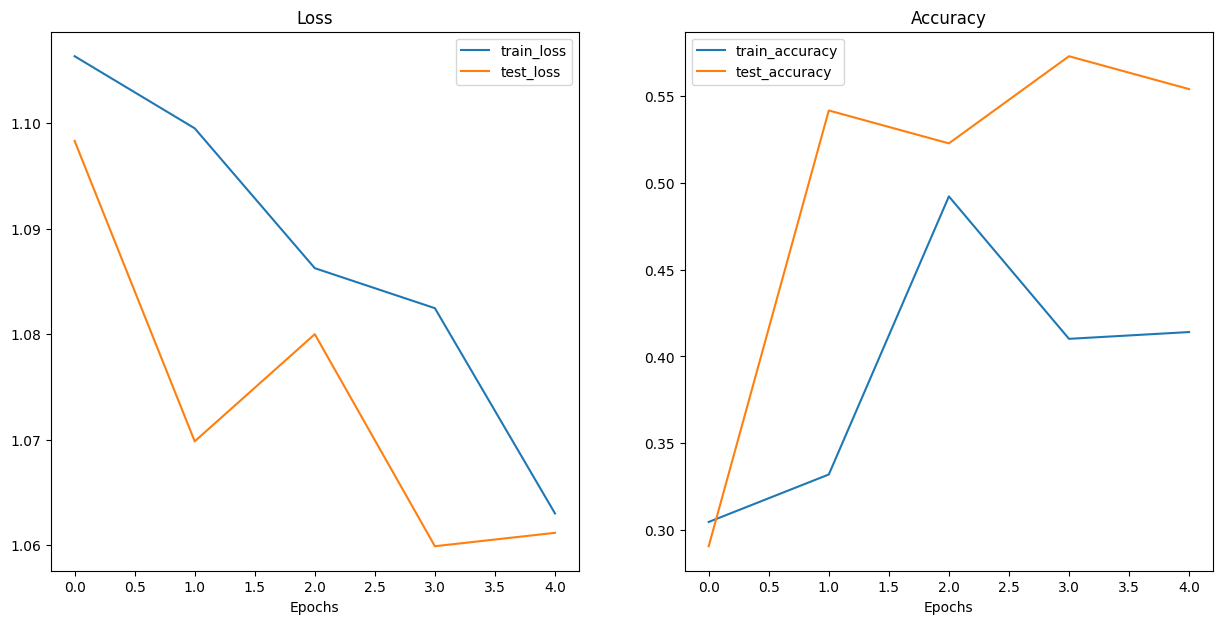

In [82]:
plot_loss_curves(model_0_results) 

## 8. What should an ideal loss curve look like?
https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation
Now let's try another modelling experiment this time using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [83]:
# Create training transform with TriviailAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                          transforms.Resize(size=(64, 64)),
                          transforms.TrivialAugmentWide(num_magnitude_bins=31),
                          transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                        transforms.Resize(size=(64, 64)),
                        transforms.ToTensor()
])

## 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [84]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                        transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                        transform=test_transform_simple)

In [85]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1
This time we'll be using the same model architecture except this time we've augmented the training data.

In [86]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
          hidden_units=10,
          output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Wonderful! Now we've a model and dataloaders, let's create a loss function and an optimizer and call upon our `train()` function to train and evaluate our model.

In [87]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
              train_dataloader=train_dataloader_augmented,
              test_dataloader=test_dataloader_simple,
              optimizer=optimizer,
              loss_fn=loss_fn,
              epochs=NUM_EPOCHS,
              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1261 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0713 | Train acc: 0.4258 | Test loss: 1.1594 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1256 | Train acc: 0.3047 | Test loss: 1.1580 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0845 | Train acc: 0.4258 | Test loss: 1.1542 | Test acc: 0.3125
Total training time for model_1: 13.272 seconds


In [ ]:
# !nvidia-smi

### 9.4 Plot the loss curves of model 1
A loss curve helps you evaluate your models performance overtime.

In [88]:
model_1_results

{'train_loss': [1.1049068570137024,
  1.0806676000356674,
  1.0713475197553635,
  1.125586986541748,
  1.0844586193561554],
 'train_acc': [0.25, 0.42578125, 0.42578125, 0.3046875, 0.42578125],
 'test_loss': [1.1019291083017986,
  1.12614107131958,
  1.1594409147898357,
  1.158018708229065,
  1.154150168100993],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.3125]}

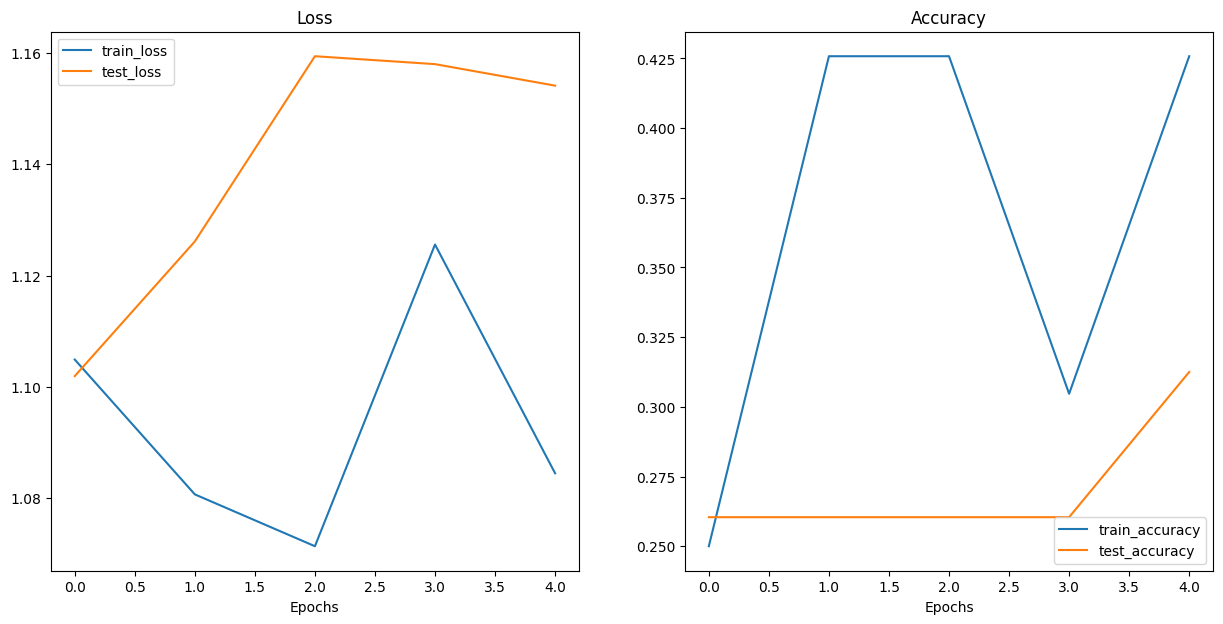

In [89]:
plot_loss_curves(model_1_results)

### 10. Compare model results
After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:

1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [90]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106343,0.304688,1.098317,0.290720
1,1.099509,0.332031,1.069840,0.541667
2,1.086252,0.492188,1.079994,0.522727
3,1.082458,0.410156,1.059897,0.572917
4,1.063005,0.414062,1.061168,0.553977


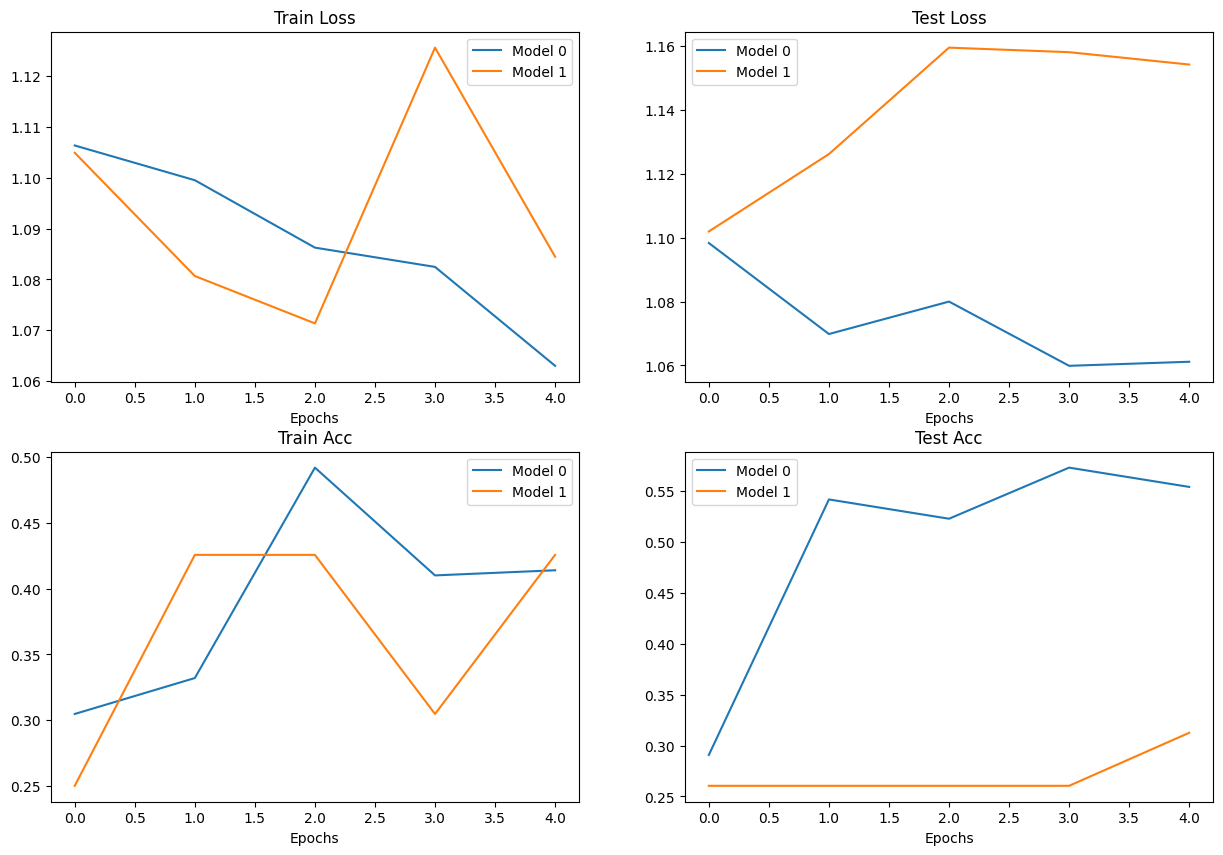

In [91]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction on a custom image
Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

### 11.1 Loading in a custom image with PyTorch
We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch using - https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [ ]:
custom_image_path

PosixPath('data/04-pizza-dad.jpeg')

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))  # (第一步)
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

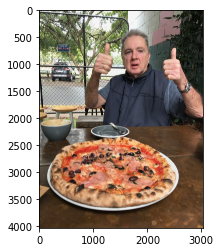

In [ ]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [ ]:
# Try to make a prediction on an image in uint8 format # 會出現錯誤，因為custom_image_unit8的type不是torch.float32
# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image_uint8.to(device))

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.  #(第二步)
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [ ]:
# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image.to(device))

# 會出現錯誤是因為custom_image大小不是64 x 64

In [ ]:
# custom_image.shape

In [ ]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
                        transforms.Resize(size=(64, 64))
])

# Transfrom target image
custom_image_transformed = custom_image_transform(custom_image)   #(第三步)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


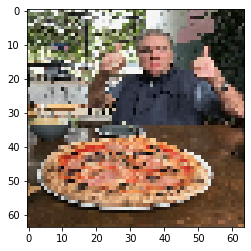

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
# This will error: image not on right device # 注意，如果不啟用GPU，這裡依然會出錯，因為batch的問題
# model_1.eval()
# with torch.inference_mode():
#   custom_image_pred = model_1(custom_image_transformed)

RuntimeError: ignored

In [ ]:
# This will error: no batch size
# model_1.eval()
# with torch.inference_mode():
#   custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: ignored

In [ ]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [ ]:
# This should this work? (added a batch size...)
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device)) #(第五步＋第六步)
custom_image_pred

tensor([[ 0.0708,  0.0490, -0.2076]], device='cuda:0')

Note, to make a prediction on a custom image we had to:

* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* Make sure the image was on the same device as our model

In [ ]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)         # 第七步
custom_image_pred_probs

tensor([[0.3656, 0.3577, 0.2767]], device='cuda:0')

In [ ]:
# Convert prediction probabilities -> prediction labels   # 這裡不用.cpu()是沒關係，但建議還是使用
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()   # 第八步
custom_image_pred_label

tensor([0])

In [ ]:
class_names[custom_image_pred_label]

'pizza'

(-0.5, 3023.5, 4031.5, -0.5)

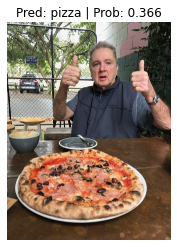

In [ ]:
# 第九-1-2-3-4步
title = f"Pred: {class_names[custom_image_pred_label.cpu()]} | Prob: {custom_image_pred_probs.max().cpu():.3f}"
plt.imshow(custom_image.squeeze().permute(1, 2, 0))
plt.title(title)
plt.axis(False)

### 11.3 Putting custom image prediction together: building a function
Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
              image_path: str,
              class_names: List[str] = None,
              transform=None,
              device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image                              #(第一步)
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) 

  # Divide the image pixel values by 255 to get them between [0, 1] #(第二步)
  target_image = target_image / 255. 

  # Transform if necessary                            #(第三步)
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)                                  #(第四步)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)                  #(第五步)

    # Make a prediction on the image with an extra dimension      #(第六步)
    target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

  # Convert logits -> prediction probabilities         
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)      #(第七步)

  # Convert predction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)   #(第八步)

  # Plot the image alongside the prediction and prediction probability  #(第九-1步)
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:                                  #(第九-2步)
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  #  以上title要被使用於matplotlib
  plt.title(title)                                  #(第九-3步)
  plt.axis(False)                                   #(第九-4步)

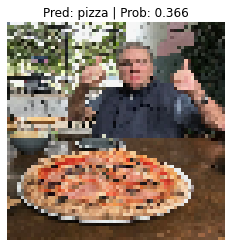

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,         # model=model_0，有不一樣的結果
          image_path=custom_image_path,
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

## Exercise

For all exercises and extra-curriculum, see here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#exercises